In [209]:
import pandas as pd
import ast
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import numpy as np

# Preprocessing

## 1. Merge Garmin and Strava Activity Datasets

In [101]:
garmin_df = pd.read_csv("erick-garmin-activities.csv")
strava_df = pd.read_csv("max-strava-activities.csv")

### 1.1 Filter for Only Runs

In [103]:
garmin_runs_df = garmin_df[garmin_df["Activity Type"] == "Running"]
strava_runs_df = strava_df[strava_df["type"] == "Run"]

### 1.2 Extract Average GAP from Strava DF

In [105]:
def compute_weighted_avg_grade_adjusted_speed(splits):
    try:
        splits = ast.literal_eval(splits)
        total_weighted_speed = sum(split['average_grade_adjusted_speed'] * split['distance'] for split in splits)
        total_distance = sum(split['distance'] for split in splits)
        weighted_avg_speed = total_weighted_speed / total_distance if total_distance != 0 else 0
        return weighted_avg_speed
    except Exception:
        return None # We will decide whether we want GAP or not later on (removes ~26 runs if not).

In [106]:
strava_runs_df["average_grade_adjusted_speed"] = strava_runs_df["splits_metric"].apply(compute_weighted_avg_grade_adjusted_speed)

### 1.3 Column Unit Conversions
| Garmin    | Garmin Units | Strava | Strava Units |
| --------- | ------------ | ------ | ------------ |
| Distance | km | distance | m |
| Avg Run Cadence | spm | average_cadence | half of garmin's value |
| Avg Pace | min/km | average_speed | m/s |
| Best Pace | min/km | max_speed | m/s |
| Avg GAP | min/km | average_grade_adjusted_speed | m/s |
| Elapsed Time | min:sec | elapsed_time | sec |
| Moving Time | min:sec | moving_time | sec |

In [108]:
def pace_to_mps(pace_str):
    if pace_str == "--":
        return None
    mins, secs = map(int, pace_str.split(":"))
    minutes_per_km = mins + secs / 60
    meters_per_second = 1000 / (minutes_per_km * 60)
    return meters_per_second

In [109]:
def time_str_to_sec(time):
    hrs, mins, secs = map(float, time.split(":"))
    return (hrs * 3600) + (mins * 60) + secs

In [110]:
# Convert Garmin units to Strava units (except cadence, which we will follow Garmin's units)
garmin_runs_df_converted = garmin_runs_df.copy()
strava_runs_df_converted = strava_runs_df.copy()
garmin_runs_df_converted["Distance"] *= 1000
# strava_runs_df_converted["average_cadence"] *= 2 # Apparently Apple Watch doesn't record cadence.
garmin_runs_df_converted["Avg Pace"] = garmin_runs_df_converted["Avg Pace"].apply(pace_to_mps)
garmin_runs_df_converted["Best Pace"] = garmin_runs_df_converted["Best Pace"].apply(pace_to_mps)
garmin_runs_df_converted["Avg GAP"] = garmin_runs_df_converted["Avg GAP"].apply(pace_to_mps)
garmin_runs_df_converted["Elapsed Time"] = garmin_runs_df_converted["Elapsed Time"].apply(time_str_to_sec)
garmin_runs_df_converted["Moving Time"] = garmin_runs_df_converted["Moving Time"].apply(time_str_to_sec)

### 1.4 Column Name Coversion & Merge

In [112]:
# Apple Watch doesn't seem to record power as well.
garmin_to_strava_cols = {
    "Distance": "distance",
    "Calories": "calories",
    "Avg HR": "average_heartrate",
    "Max HR": "max_heartrate",
    # "Avg Run Cadence": "average_cadence",
    "Avg Pace": "average_speed",
    "Best Pace": "max_speed",
    "Avg GAP": "average_grade_adjusted_speed",
    "Total Ascent": "total_elevation_gain",
    # "Avg Power": "average_watts",
    # "Max Power": "max_watts",
    "Elapsed Time": "elapsed_time",
    "Moving Time": "moving_time",
    "Min Elevation": "elev_low",
    "Max Elevation": "elev_high"
}

In [113]:
garmin_runs_df_converted = garmin_runs_df_converted.rename(columns=garmin_to_strava_cols)

desired_columns = list(garmin_to_strava_cols.values())
garmin_filtered_df = garmin_runs_df_converted[desired_columns]
strava_filtered_df = strava_runs_df_converted[desired_columns]

combined_df = pd.concat([garmin_filtered_df, strava_filtered_df], ignore_index=True)

# 2. Data Cleaning

In [225]:
# Dropped runs with null heartrate, grade adjusted speed, and elevation, reducing our data set by about 30 runs in total.
# figured this was better than replacing null values with averages
combined_df_null_removed = combined_df.dropna(subset=['average_heartrate', 'average_grade_adjusted_speed', 'elev_low', 'elev_high']).reset_index(drop=True)
combined_df_null_removed

,distance,calories,average_heartrate,max_heartrate,average_speed,max_speed,average_grade_adjusted_speed,total_elevation_gain,elapsed_time,moving_time,elev_low,elev_high
0,6510.0,351,158,175,3.311258,10.309278,3.311258,37,2014.0,1964.0,324,346
1,6180.0,317,149,171,3.322259,3.968254,3.300330,23,2005.0,1852.0,178,190
2,5040.0,269,156,170,3.267974,3.521127,3.257329,21,1580.0,1538.0,169,186
3,4930.0,259,157,169,3.378378,4.716981,3.355705,41,1492.0,1458.0,328,350
4,5510.0,297,156,171,3.194888,4.184100,3.154574,27,1778.0,1714.0,337,351
...,...,...,...,...,...,...,...,...,...,...,...,...
384,10473.1,530.0,143.8,166.0,3.035000,4.500000,3.027005,130.2,3847.0,3451.0,106.1,190.2
385,10309.2,536.0,150.6,172.0,2.652000,5.200000,2.737829,109.2,3941.0,3888.0,34.6,148.9
386,9971.0,518.0,142.6,175.0,2.912000,5.200000,3.174127,146.1,3458.0,3424.0,106.1,152.2
387,1836.2,91.0,112.0,112.0,3.680000,5.300000,3.598320,10.6,499.0,499.0,118.3,189.8


In [226]:
# Remove runs that have data that is above or below 3 z-scores of the average for its column, besides for distance and moving_time which can be highly variable
columns_to_include = [col for col in combined_df_null_removed.select_dtypes(include=['float64', 'int64']).columns if col not in ['distance', 'moving_time']]
z_scores = stats.zscore(combined_df_null_removed[columns_to_include])
z_score_threshold = 3
mask = (abs(z_scores) < z_score_threshold).all(axis=1)
combined_df_filtered = combined_df_null_removed[mask].reset_index(drop=True)

combined_df_filtered

,distance,calories,average_heartrate,max_heartrate,average_speed,max_speed,average_grade_adjusted_speed,total_elevation_gain,elapsed_time,moving_time,elev_low,elev_high
0,6510.0,351,158,175,3.311258,10.309278,3.311258,37,2014.0,1964.0,324,346
1,6180.0,317,149,171,3.322259,3.968254,3.300330,23,2005.0,1852.0,178,190
2,5040.0,269,156,170,3.267974,3.521127,3.257329,21,1580.0,1538.0,169,186
3,4930.0,259,157,169,3.378378,4.716981,3.355705,41,1492.0,1458.0,328,350
4,5510.0,297,156,171,3.194888,4.184100,3.154574,27,1778.0,1714.0,337,351
...,...,...,...,...,...,...,...,...,...,...,...,...
368,10473.1,530.0,143.8,166.0,3.035000,4.500000,3.027005,130.2,3847.0,3451.0,106.1,190.2
369,10309.2,536.0,150.6,172.0,2.652000,5.200000,2.737829,109.2,3941.0,3888.0,34.6,148.9
370,9971.0,518.0,142.6,175.0,2.912000,5.200000,3.174127,146.1,3458.0,3424.0,106.1,152.2
371,1836.2,91.0,112.0,112.0,3.680000,5.300000,3.598320,10.6,499.0,499.0,118.3,189.8


In [227]:
# Remove commas and spaces before converting to numeric
combined_df_filtered['elev_low'] = combined_df_filtered['elev_low'].replace({',': '', ' ': ''}, regex=True)
combined_df_filtered['elev_high'] = combined_df_filtered['elev_high'].replace({',': '', ' ': ''}, regex=True)

# Convert object columns to be numeric
combined_df_filtered['calories'] = pd.to_numeric(combined_df_filtered['calories'], errors='coerce')
combined_df_filtered['average_heartrate'] = pd.to_numeric(combined_df_filtered['average_heartrate'], errors='coerce')
combined_df_filtered['max_heartrate'] = pd.to_numeric(combined_df_filtered['max_heartrate'], errors='coerce')
combined_df_filtered['total_elevation_gain'] = pd.to_numeric(combined_df_filtered['total_elevation_gain'], errors='coerce')
combined_df_filtered['elev_low'] = pd.to_numeric(combined_df_filtered['elev_low'], errors='coerce')
combined_df_filtered['elev_high'] = pd.to_numeric(combined_df_filtered['elev_high'], errors='coerce')

## 3. Feature Scaling

In [228]:
# Standardize data to have a mean of 0 and a standard deviation of 1
columns_to_scale = combined_df_filtered.select_dtypes(include=['float64', 'int64']).columns.difference(['calories'])
scaler = StandardScaler()
combined_df_scaled = combined_df_filtered.copy()  # Create a copy to keep the original intact
combined_df_scaled[columns_to_scale] = scaler.fit_transform(combined_df_scaled[columns_to_scale])
combined_df_scaled

,distance,calories,average_heartrate,max_heartrate,average_speed,max_speed,average_grade_adjusted_speed,total_elevation_gain,elapsed_time,moving_time,elev_low,elev_high
0,0.624165,351.0,1.116701,0.776841,0.660822,3.558670,0.473422,-0.572274,0.218892,0.431056,1.185317,1.095404
1,0.446882,317.0,0.174966,0.386458,0.703884,-0.876152,0.431843,-0.943081,0.204640,0.243666,-0.017587,-0.347607
2,-0.165550,269.0,0.907427,0.288862,0.491389,-1.188867,0.268236,-0.996054,-0.468382,-0.281695,-0.091739,-0.384607
3,-0.224644,259.0,1.012064,0.191267,0.923559,-0.352503,0.642528,-0.466329,-0.607737,-0.415545,1.218273,1.132404
4,0.086944,297.0,0.907427,0.386458,0.205301,-0.725192,-0.122718,-0.837136,-0.154833,0.012775,1.292424,1.141654
...,...,...,...,...,...,...,...,...,...,...,...,...
368,2.753226,530.0,-0.369148,-0.101521,-0.420569,-0.504257,-0.608085,1.896246,3.121595,2.918991,-0.609976,-0.345757
369,2.665175,536.0,0.342385,0.484054,-1.919791,-0.014687,-1.708317,1.340035,3.270451,3.650146,-1.199069,-0.727784
370,2.483487,518.0,-0.494713,0.776841,-0.902042,-0.014687,-0.048326,2.317378,2.505582,2.873817,-0.609976,-0.697259
371,-1.886699,91.0,-3.696613,-5.371691,2.104232,0.055252,1.565614,-1.271511,-2.180232,-2.020070,-0.509459,-0.349457


# 4. Feature Selection

## 4.1 Recursive Feature Elimination

In [230]:
# Split the data into features and target.
X = combined_df_scaled.drop(columns=["calories"])
y = combined_df_scaled["calories"]

In [231]:
# Check the range and basic stats of calories.
print(f"Calorie mean: {y.mean()}")
print(f"Calorie std: {y.std()}")
print(f"Calorie min: {y.min()}")
print(f"Calorie max: {y.max()}")

Calorie mean: 286.3190348525469
Calorie std: 98.86913033095476
Calorie min: 55.0
Calorie max: 677.0


RandomForest with 2 Features: Mean RMSE -15.709362752783301 (3.300685911243228)
GradientBoosting with 2 Features: Mean RMSE -15.5173835609044 (3.4630428501737103)
LinearRegression with 2 Features: Mean RMSE -13.582448408963272 (2.8599130846229883)
RandomForest with 3 Features: Mean RMSE -15.223289382301168 (3.3855932183429527)
GradientBoosting with 3 Features: Mean RMSE -15.378474460904133 (3.869808214738535)
LinearRegression with 3 Features: Mean RMSE -13.139926413633253 (2.7362232626863663)
RandomForest with 4 Features: Mean RMSE -14.981712226948629 (3.5752110321401305)
GradientBoosting with 4 Features: Mean RMSE -14.287193252699943 (3.376730332720626)
LinearRegression with 4 Features: Mean RMSE -12.83066921646397 (2.442080798230801)
RandomForest with 5 Features: Mean RMSE -15.08636985352892 (3.445793716504454)
GradientBoosting with 5 Features: Mean RMSE -14.024142977234456 (3.2069271586142656)
LinearRegression with 5 Features: Mean RMSE -12.195899350798248 (2.551702028180409)
Random

/var/folders/0t/_s8j_7ms1cq3fylk4_bsdzkc0000gp/T/ipykernel_5011/2257595549.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(model_results['RandomForest'], labels=feature_counts, showmeans=True)
/var/folders/0t/_s8j_7ms1cq3fylk4_bsdzkc0000gp/T/ipykernel_5011/2257595549.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(model_results['GradientBoosting'], labels=feature_counts, showmeans=True)
/var/folders/0t/_s8j_7ms1cq3fylk4_bsdzkc0000gp/T/ipykernel_5011/2257595549.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(model_results['LinearRegression'], labels=feature_counts, sho

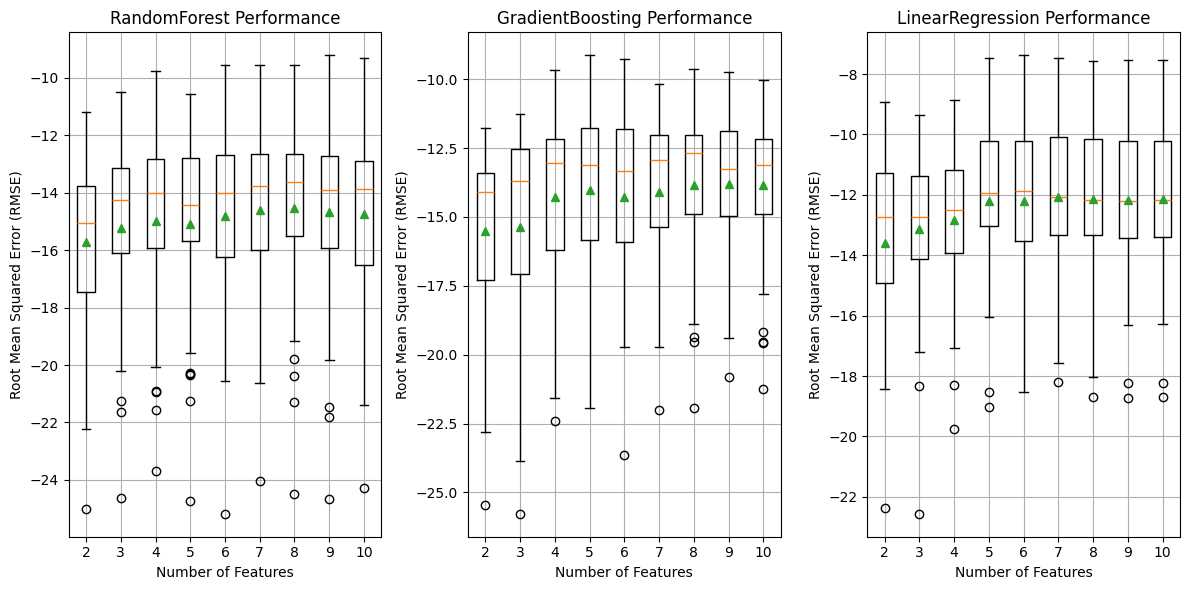

In [232]:
models = {
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "LinearRegression": LinearRegression()
}
feature_counts = [2,3,4,5,6,7,8,9,10]
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
model_results = {
    "RandomForest": [],
    "GradientBoosting": [],
    "LinearRegression": []
}

for n_features in feature_counts:
    for model_name, model in models.items():
        pipeline = Pipeline(steps=[
            ('s', RFE(estimator=model, n_features_to_select=n_features)),
            ('m', model)
        ])
        
        scores = cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)        
        model_results[model_name].append(scores)
        print(f"{model_name} with {n_features} Features: Mean RMSE {np.mean(scores)} ({np.std(scores)})")

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.boxplot(model_results['RandomForest'], labels=feature_counts, showmeans=True)
plt.title('RandomForest Performance')
plt.xlabel('Number of Features')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.boxplot(model_results['GradientBoosting'], labels=feature_counts, showmeans=True)
plt.title('GradientBoosting Performance')
plt.xlabel('Number of Features')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.boxplot(model_results['LinearRegression'], labels=feature_counts, showmeans=True)
plt.title('LinearRegression Performance')
plt.xlabel('Number of Features')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [233]:
# Use Linear Regression as estimator and select 7 features.
rfe = RFE(estimator=LinearRegression(), n_features_to_select=7)
rfe.fit(X, y)

X_columns = list(X.columns)
for i in range(len(X_columns)):
    print(f"Column: {X_columns[i]}, Selected: {rfe.support_[i]}, Rank: {rfe.ranking_[i]}")

Column: distance, Selected: True, Rank: 1
Column: average_heartrate, Selected: True, Rank: 1
Column: max_heartrate, Selected: False, Rank: 4
Column: average_speed, Selected: True, Rank: 1
Column: max_speed, Selected: False, Rank: 2
Column: average_grade_adjusted_speed, Selected: False, Rank: 3
Column: total_elevation_gain, Selected: True, Rank: 1
Column: elapsed_time, Selected: True, Rank: 1
Column: moving_time, Selected: True, Rank: 1
Column: elev_low, Selected: False, Rank: 5
Column: elev_high, Selected: True, Rank: 1


In [ ]:
# Filter selected columns/features.
selected_columns = X.columns[rfe.support_]
combined_df_scaled_filtered = combined_df_scaled[selected_columns]
combined_df_scaled_filtered

,distance,average_heartrate,average_speed,total_elevation_gain,elapsed_time,moving_time,elev_high
0,0.624165,1.116701,0.660822,-0.572274,0.218892,0.431056,1.095404
1,0.446882,0.174966,0.703884,-0.943081,0.204640,0.243666,-0.347607
2,-0.165550,0.907427,0.491389,-0.996054,-0.468382,-0.281695,-0.384607
3,-0.224644,1.012064,0.923559,-0.466329,-0.607737,-0.415545,1.132404
4,0.086944,0.907427,0.205301,-0.837136,-0.154833,0.012775,1.141654
...,...,...,...,...,...,...,...
368,2.753226,-0.369148,-0.420569,1.896246,3.121595,2.918991,-0.345757
369,2.665175,0.342385,-1.919791,1.340035,3.270451,3.650146,-0.727784
370,2.483487,-0.494713,-0.902042,2.317378,2.505582,2.873817,-0.697259
371,-1.886699,-3.696613,2.104232,-1.271511,-2.180232,-2.020070,-0.349457
